<a href="https://colab.research.google.com/github/keijiyo/Study_AI_recipe_book/blob/main/AI_Recipe_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Part 2　顧客データ×クラスタリング分析モデル

In [ ]:
# Part 2

## Introduction
顧客データを分類して業務改善したい  ～クラスタリング～

##レシピ2.1　データの準備

分析前に仕様書でデータ形式や入力内容を確認する

##レシピ2.2　マスタデータの作成

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

# 顧客情報読込
kokyaku = pd.read_csv('drive/My Drive/ai_recipe/顧客情報.csv', encoding = 'CP932') # 自作csv読込がエラーになったので、encoding: 'shift-jis'→'CP932'に変更
# 契約情報読込
keiyaku = pd.read_csv('drive/My Drive/ai_recipe/契約情報.csv', encoding = 'CP932') # 自作csv読込がエラーになったので、encoding: 'shift-jis'→'CP932'に変更
# 利用履歴読込
riyo_ri = pd.read_csv('drive/My Drive/ai_recipe/利用履歴.csv', encoding = 'CP932') # 自作csv読込がエラーになったので、encoding: 'shift-jis'→'CP932'に変更


# 顧客情報に契約情報を結合
kokyaku_keiyaku = pd.merge(kokyaku, keiyaku,
                           on='顧客番号', how='left')

# さらに利用履歴を結合
kokyaku_riyo_ri = pd.merge(kokyaku_keiyaku, riyo_ri,
                           on='カード番号', how='left')

# データの確認
kokyaku_riyo_ri

,顧客番号,顧客名,カード番号,契約日,利用日,利用額
0,101,A,1001,20190304,20191002.0,5000.0
1,101,A,1001,20190304,20200808.0,2000.0
2,101,A,1001,20190304,20200901.0,100.0
3,101,A,1001,20190304,20200911.0,1000.0
4,101,A,1001,20190304,20201008.0,2000.0
5,101,A,1001,20190304,20201012.0,40000.0
6,101,A,1001,20190304,20201111.0,10000.0
7,101,A,1001,20190304,20201115.0,3000.0
8,101,A,1001,20190304,20201127.0,50000.0
9,101,A,1002,20170506,20201102.0,200.0


月別利用額の算出

In [4]:
# 利用月という項目を作成
kokyaku_riyo_ri['利用月'] = kokyaku_riyo_ri['利用日']\
.dropna(axis=0).astype(str).str[:6]

# 顧客名と利用月で利用額を集約
kokyaku_riyo_ri.groupby(['顧客名', '利用月']).sum().利用額

顧客名  利用月   
A    201910     5000.0
     202008     2000.0
     202009     1100.0
     202010    42000.0
     202011    63600.0
B    201902      500.0
     201903     6700.0
     201905    20000.0
     202001     3000.0
Name: 利用額, dtype: float64

## レシピ2.3　データの基礎集計と可視化

In [5]:
import pandas as pd

CC_GENERAL = pd.read_csv('drive/My Drive/ai_recipe/CC GENERAL.csv')

In [6]:
CC_GENERAL.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


基礎統計量の確認

In [7]:
CC_GENERAL.describe().T

,count,mean,std,min,25%,50%,75%,max
BALANCE,8950.0,1564.474828,2081.531879,0.000000,128.281915,873.385231,2054.140036,19043.13856
BALANCE_FREQUENCY,8950.0,0.877271,0.236904,0.000000,0.888889,1.000000,1.000000,1.00000
PURCHASES,8950.0,1003.204834,2136.634782,0.000000,39.635000,361.280000,1110.130000,49039.57000
ONEOFF_PURCHASES,8950.0,592.437371,1659.887917,0.000000,0.000000,38.000000,577.405000,40761.25000
INSTALLMENTS_PURCHASES,8950.0,411.067645,904.338115,0.000000,0.000000,89.000000,468.637500,22500.00000
CASH_ADVANCE,8950.0,978.871112,2097.163877,0.000000,0.000000,0.000000,1113.821139,47137.21176
PURCHASES_FREQUENCY,8950.0,0.490351,0.401371,0.000000,0.083333,0.500000,0.916667,1.00000
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.202458,0.298336,0.000000,0.000000,0.083333,0.300000,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.364437,0.397448,0.000000,0.000000,0.166667,0.750000,1.00000
CASH_ADVANCE_FREQUENCY,8950.0,0.135144,0.200121,0.000000,0.000000,0.000000,0.222222,1.50000


欠損値の有無の確認

In [8]:
CC_GENERAL.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

欠損値の補完

In [9]:
CC_GENERAL.fillna(CC_GENERAL.median())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,312.343947,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,C19186,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6
8946,C19187,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,312.343947,0.000000,6
8947,C19188,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6
8948,C19189,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6


変数分布の確認
- 箱ひげ図
- ヒストグラム

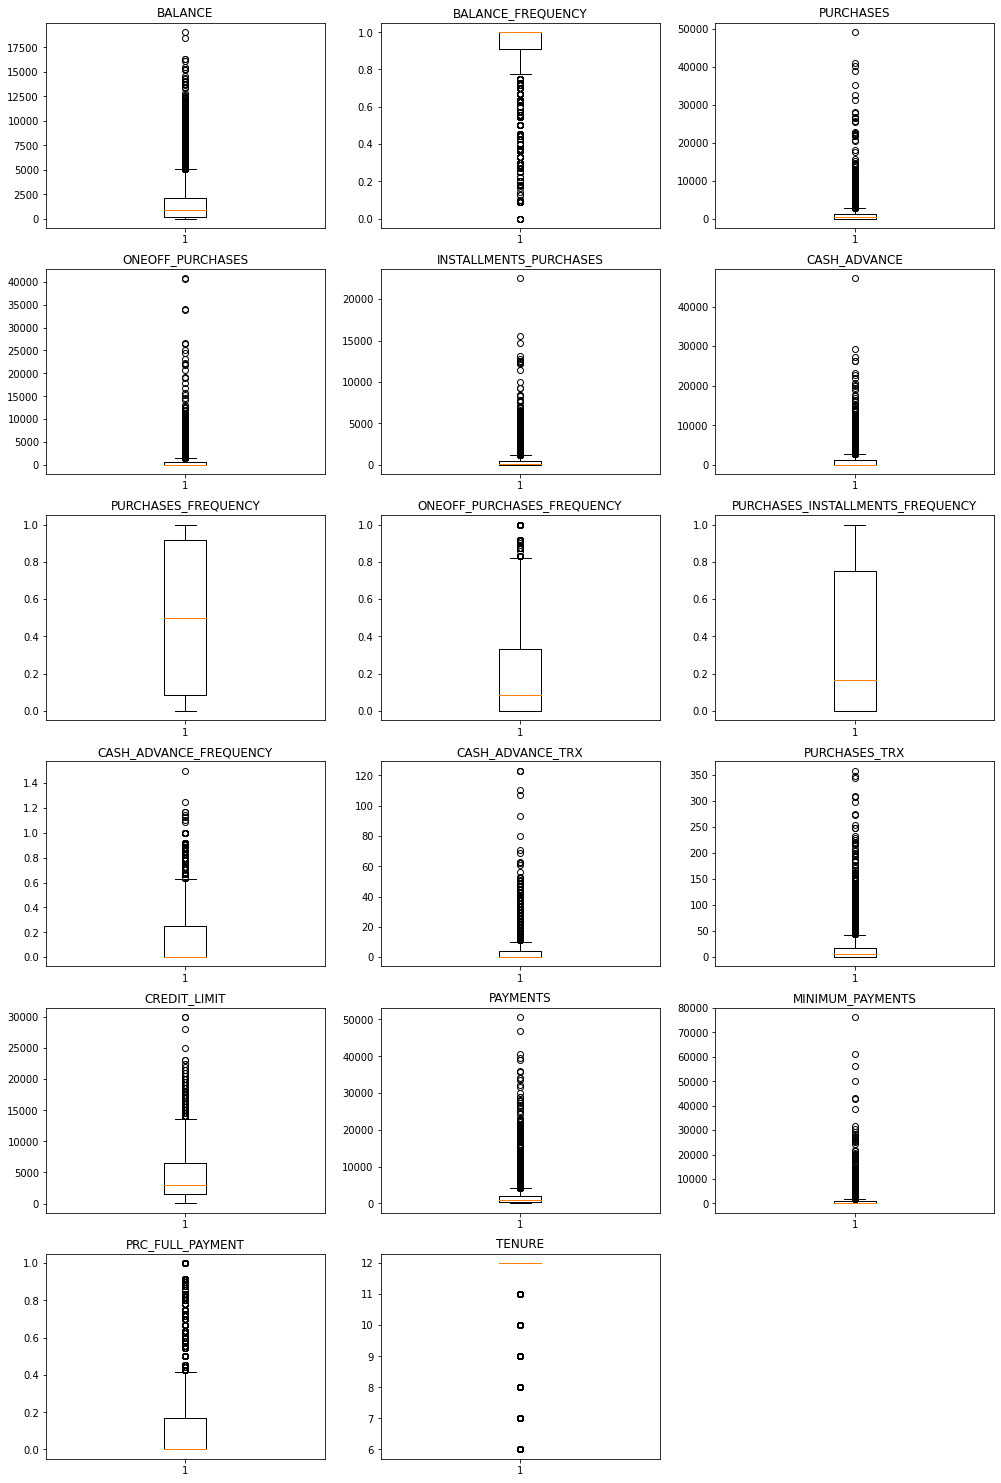

In [10]:
#箱ひげ図の作成

#numpy,matplotの呼び出し
import numpy as np
import matplotlib.pyplot as plt

#必要項目
CC_GENERAL_plt = CC_GENERAL.drop("CUST_ID", axis=1)

#プロットエリアの指定
fig = plt.figure(figsize=(17, 40))

#グラフの出力
for i in np.arange((CC_GENERAL_plt.shape[1])):
    plt.subplot(9,3,i+1)
    plt.boxplot(CC_GENERAL_plt.dropna().iloc[:,i])
    plt.title(CC_GENERAL_plt.columns[i])

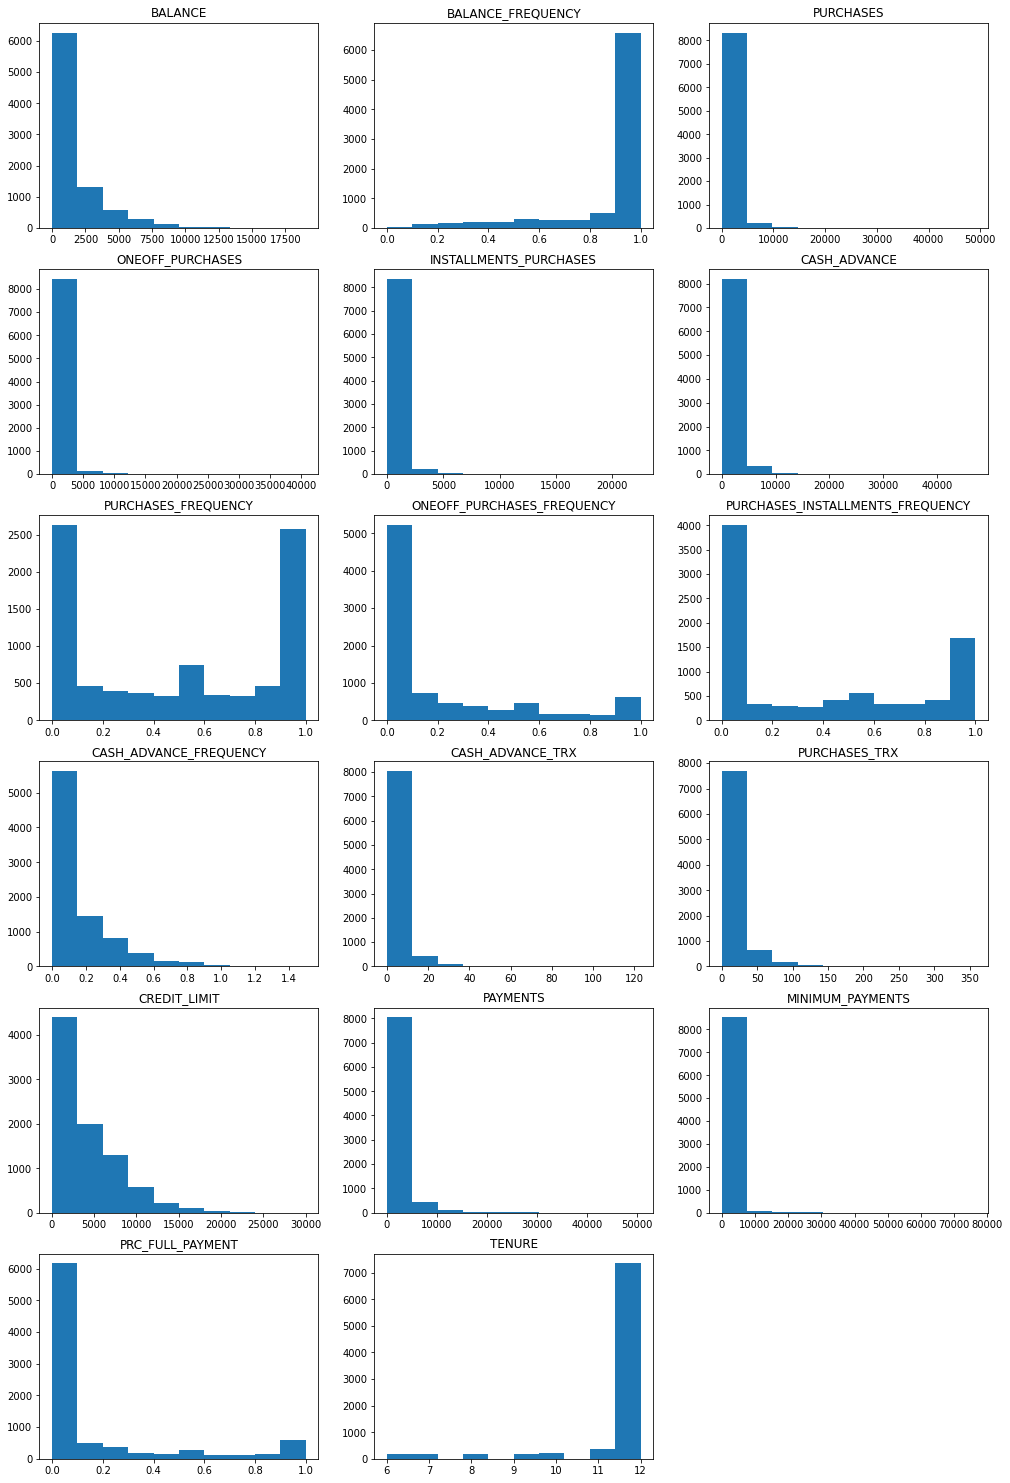

In [11]:
#プロットエリアの指定
fig = plt.figure(figsize=(17, 40))

#グラフの出力
for i in np.arange((CC_GENERAL_plt.shape[1])):
    plt.subplot(9,3,i+1)
    plt.hist(CC_GENERAL_plt.dropna().iloc[:,i], bins=10)
    plt.title(CC_GENERAL_plt.columns[i])

## レシピ2.4　クラスタリングの実行
2変数について k-平均法で分類

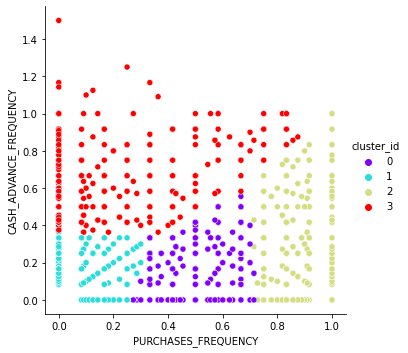

In [ ]:
from sklearn.cluster import KMeans
import seaborn as sns
import numpy as np

# 2変数の選択
CC_GENERAL_a = np.array(CC_GENERAL[['PURCHASES_FREQUENCY',
                                    'CASH_ADVANCE_FREQUENCY']])

# k-平均法の実行
predict = KMeans(n_clusters=4).fit_predict(CC_GENERAL_a)
CC_GENERAL['cluster_id'] = predict

# 結果を表示
sns.relplot(x='PURCHASES_FREQUENCY',
            y='CASH_ADVANCE_FREQUENCY',
            hue='cluster_id',
            palette='rainbow',
            data=CC_GENERAL)

5変数の各ペアについて k-平均法で分類

In [ ]:
from sklearn import preprocessing

# 変数の選択
CC_GENERAL_b = CC_GENERAL[['PURCHASES_FREQUENCY',
                           'ONEOFF_PURCHASES_FREQUENCY', 
                           'PURCHASES_INSTALLMENTS_FREQUENCY',
                           'CASH_ADVANCE_FREQUENCY',
                           'CREDIT_LIMIT'
                          ]].fillna(0)

#各項目を標準化(平均を0、標準偏差を1とする)
CC_GENERAL_c = preprocessing.scale(CC_GENERAL_b)

# k-平均法の実行
# クラスター数:5
cls = KMeans(n_clusters=5, random_state=111)
predict = cls.fit_predict(CC_GENERAL_c)
CC_GENERAL_b['cluster_id'] = predict

分布の確認　ペアプロット

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 2880x1440 with 0 Axes>

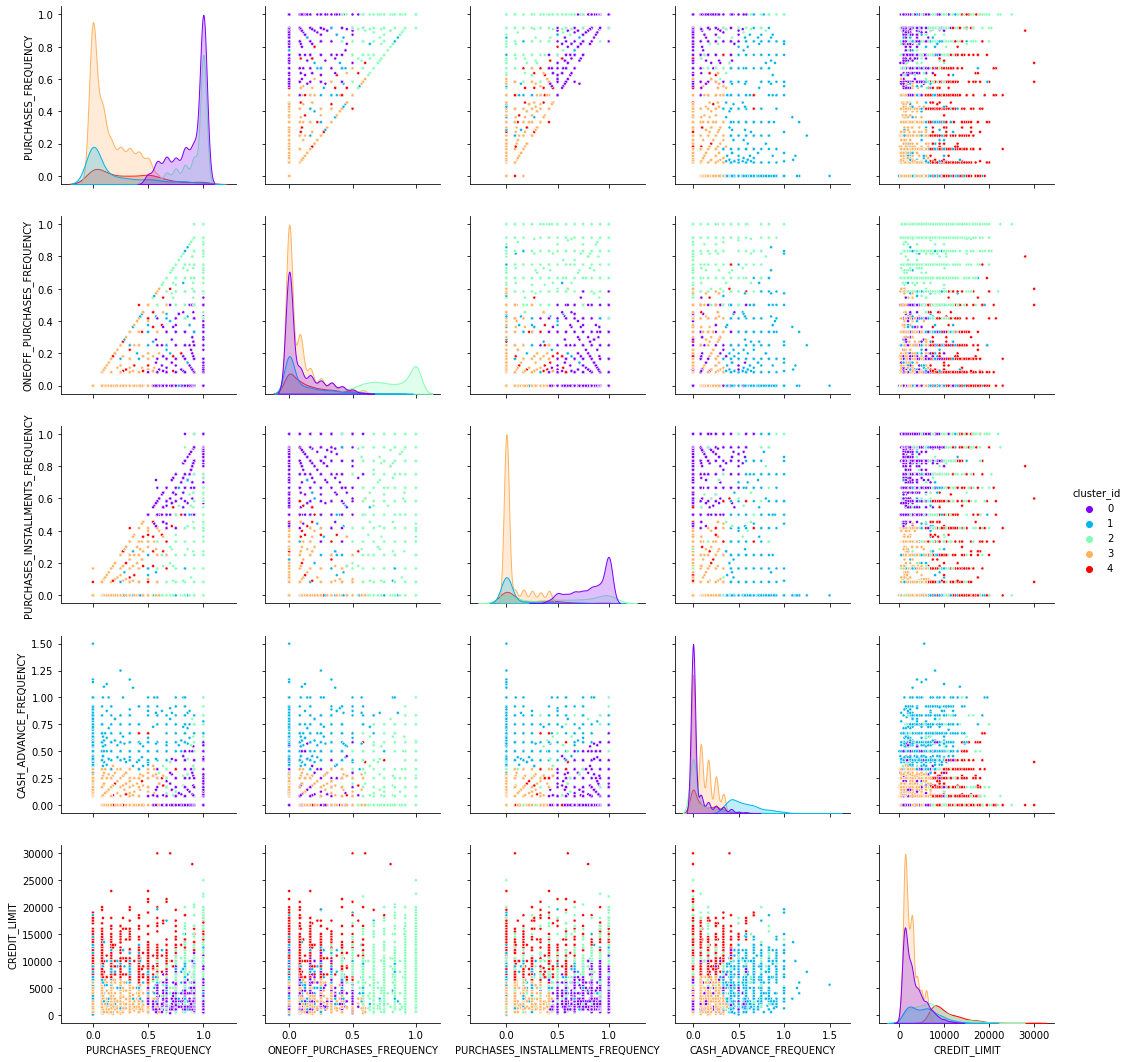

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 20))
sns.pairplot(CC_GENERAL_b, hue='cluster_id', markers='.',
             size=3, palette='rainbow')

平均値の確認

In [ ]:
grouped = CC_GENERAL_b.groupby('cluster_id')
grouped.mean()

,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CREDIT_LIMIT
cluster_id,,,,,
0,0.882208,0.088789,0.831104,0.050332,3240.179562
1,0.174844,0.092709,0.091078,0.562423,5448.741188
2,0.923973,0.809601,0.534492,0.079441,6914.335715
3,0.155846,0.084537,0.068982,0.099867,2649.001615
4,0.312613,0.134351,0.195050,0.108075,10527.524012


クラスタ件数の確認

In [ ]:
CC_GENERAL_b['cluster_id'].value_counts().sort_index()

0    2467
1     993
2    1374
3    3302
4     814
Name: cluster_id, dtype: int64

分布の確認　ヒストグラム

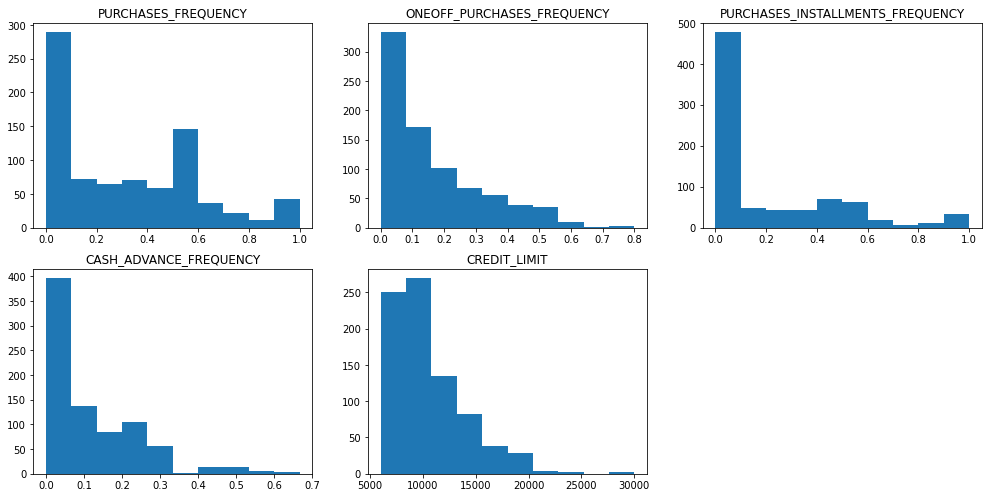

In [ ]:
# cluster_id=4
CC_GENERAL_b_4 = CC_GENERAL_b.query('cluster_id == 4')\
.drop('cluster_id', axis=1)


#プロットエリアの指定
fig = plt.figure(figsize=(17, 40))

#グラフの出力
for i in np.arange((CC_GENERAL_b_4.shape[1])):
    plt.subplot(9,3,i+1)
    plt.hist(CC_GENERAL_b_4.dropna().iloc[:,i], bins=10)
    plt.title(CC_GENERAL_b_4.columns[i])

5変数の各ペアについて 階層クラスタリングで分類

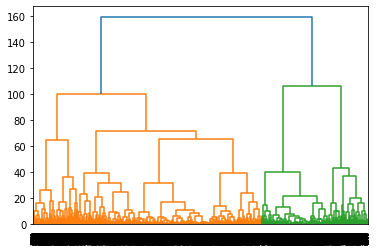

In [ ]:
from scipy.cluster.hierarchy import linkage,dendrogram,cut_tree

# 変数の選択
CC_GENERAL_b_2 = CC_GENERAL[['PURCHASES_FREQUENCY',
                             'ONEOFF_PURCHASES_FREQUENCY', 
                             'PURCHASES_INSTALLMENTS_FREQUENCY',
                             'CASH_ADVANCE_FREQUENCY',
                             'CREDIT_LIMIT'
                            ]].fillna(0)


#各項目を標準化(平均を0、標準偏差を1とする)
CC_GENERAL_c_2 = preprocessing.scale(CC_GENERAL_b_2)

CC_GENERAL_c_cls = linkage(CC_GENERAL_c_2,
                           metric='euclidean', method='ward')
dend = dendrogram(CC_GENERAL_c_cls)

分布の確認

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


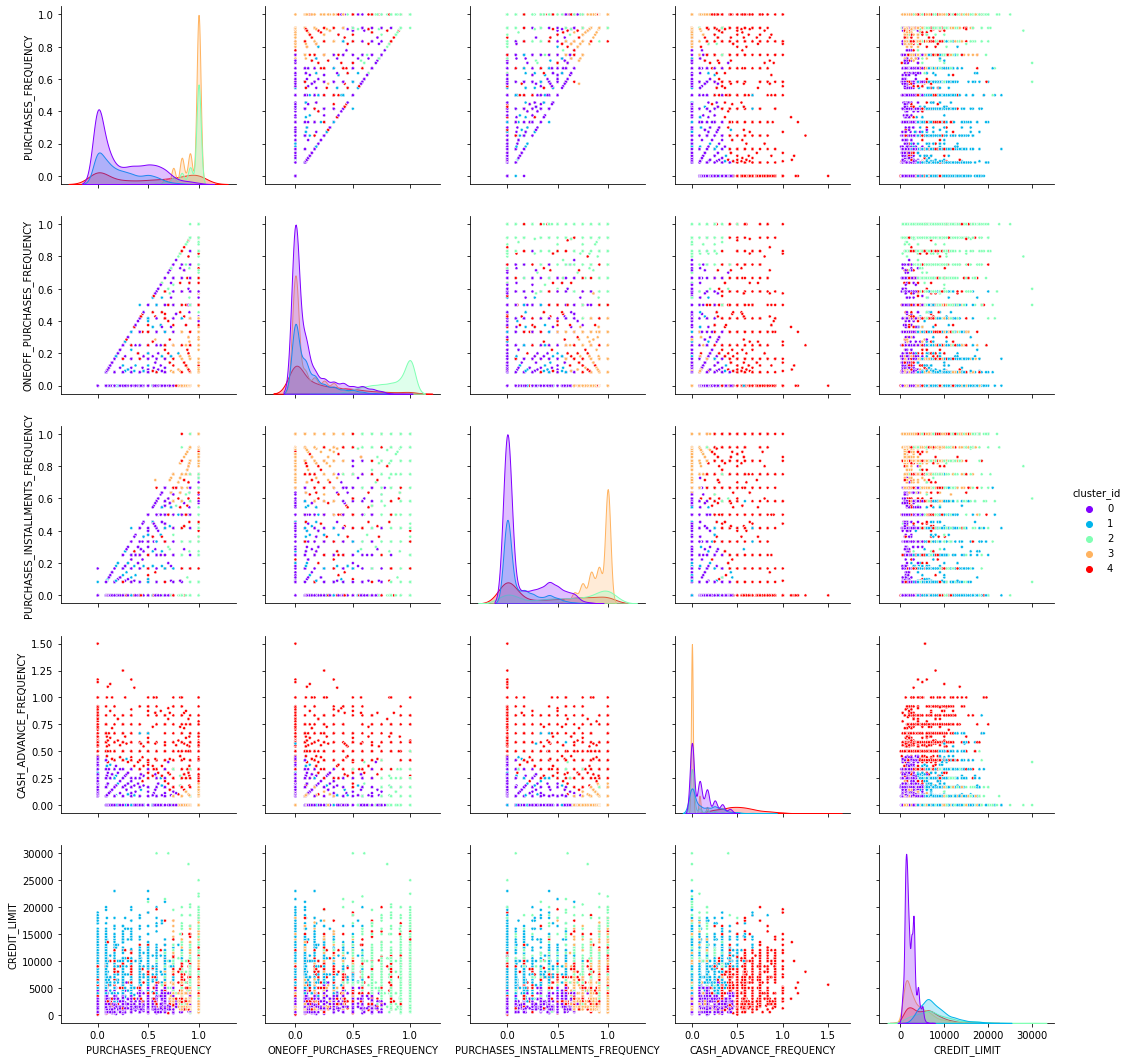

In [ ]:
#クラスターの数は5とする
CC_GENERAL_cuttree = cut_tree(CC_GENERAL_c_cls, n_clusters = 5)

#元のデータにクラスタ番号を付与
CC_GENERAL_b_2['cluster_id'] = CC_GENERAL_cuttree

#図表の出力
sns.pairplot(CC_GENERAL_b_2, hue='cluster_id', markers='.',
             size=3, palette='rainbow')

平均値の確認

In [ ]:
grouped = CC_GENERAL_b_2.groupby('cluster_id')
grouped.mean()

,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CREDIT_LIMIT
cluster_id,,,,,
0,0.238039,0.107741,0.137776,0.100395,2167.736804
1,0.207863,0.104792,0.105402,0.117538,7775.592039
2,0.953812,0.849274,0.572658,0.036267,7461.119013
3,0.946023,0.080082,0.907479,0.016316,3690.027517
4,0.473592,0.203474,0.341471,0.519036,5302.500000


クラスタ件数の確認

In [ ]:
CC_GENERAL_b_2['cluster_id'].value_counts().sort_index()

0    3349
1    1556
2    1061
3    1784
4    1200
Name: cluster_id, dtype: int64

## レシピ2.5　分類報告書の作成

書籍には階層クラスタリングの例で記載あり。

分析レポートの構成例
1. 分析の目的  
1. 分析手法の説明
1. 使用したデータや、加工方法
1. 分析の結果
1. 結論と考察